# Домашнее задание №9
## Линейная регрессия
### PROC REG

_[Гончаренко Дмитрий Александрович, Жуков Павел Николаевич, Слабоузова Анна Константиновна]_

### 0. Подготовка файлов для выполнения ДЗ.
Вместе с этим файлом в архиве находится программа для создания набора данных _BodyFat_ для выполнения ДЗ: 
- FATDATAREG.sas;

Для вашего удобства в программе создаются макропеременные: с целевой переменной, предикторами и названием набора данных для анализа.


### Задание


### 1. Предварительное  исследование данных  
С помощью процедуры `proc corr` исследуйте корреляцию между целевой переменной и предикторами.
- в процедуре постройте графики типа scatter для визуального исследования характера зависимости (используя опции, постройте графики для **всех** предикторов);
- сохраните результаты работы процедуры - коэф. корреляции Пирсона и соответствующее p-value по всем предикторам - в набор данных (используйте операторы ods output ...; и ods trace ...;);
- исключите из анализа предикторы, для которых нельзя отклонить гипотезу о равенстве коэффициента корреляции нулю (уровень значимости 0.05), и предикторы, у которых корреляция < 0.3;
- с помощью процедуры proc sql (конструкция select ... into: separated by ' ') создайте макропеременную inputs, которая будет содержать список оставшихся переменных, разделенных пробелами. 

In [1]:
%include 'FATDATAREG.sas'

SAS Connection established. Subprocess id is 2541




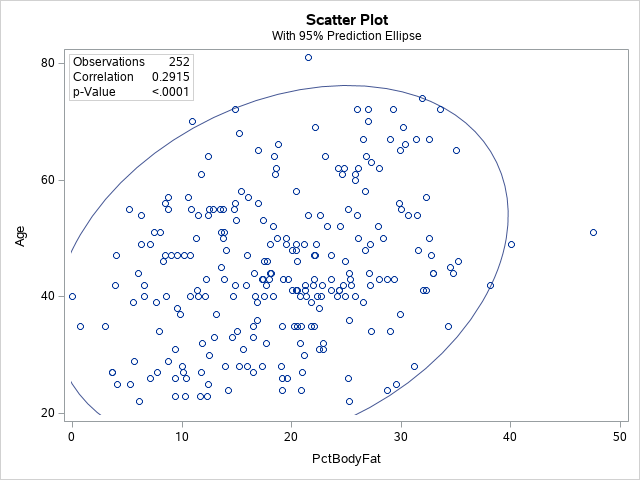
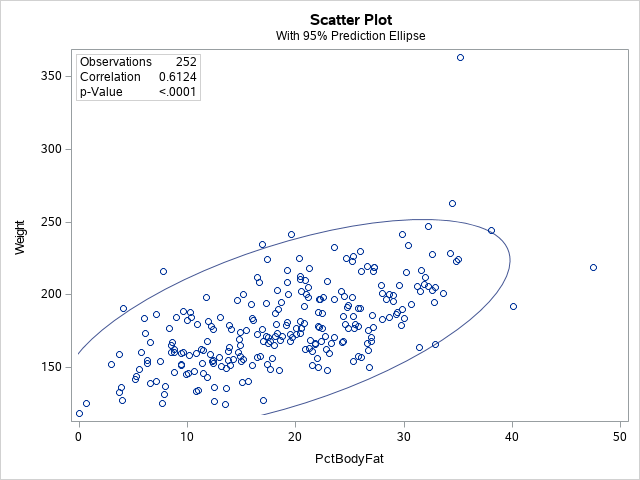
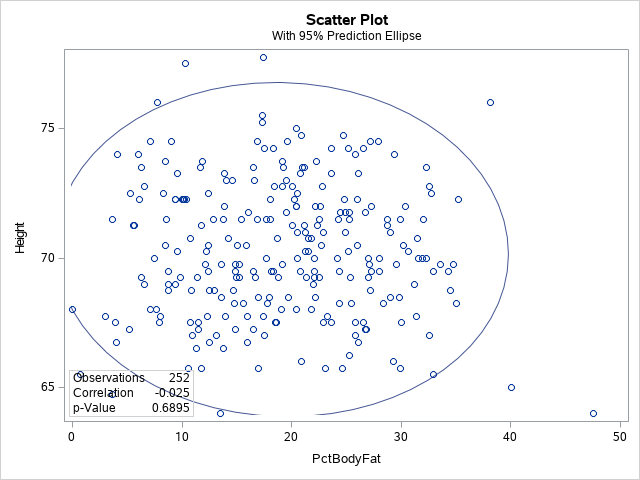
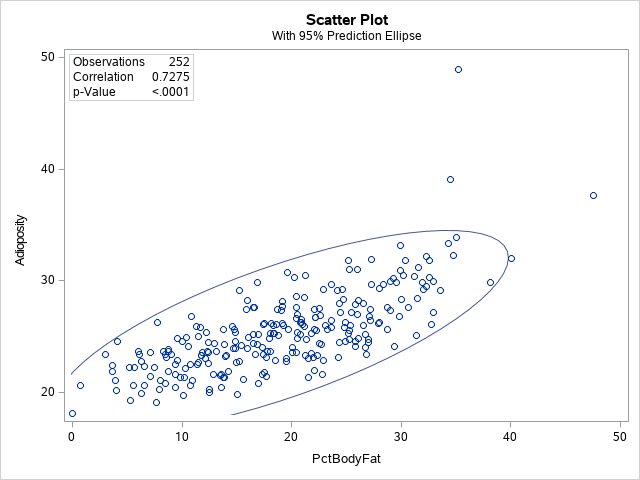
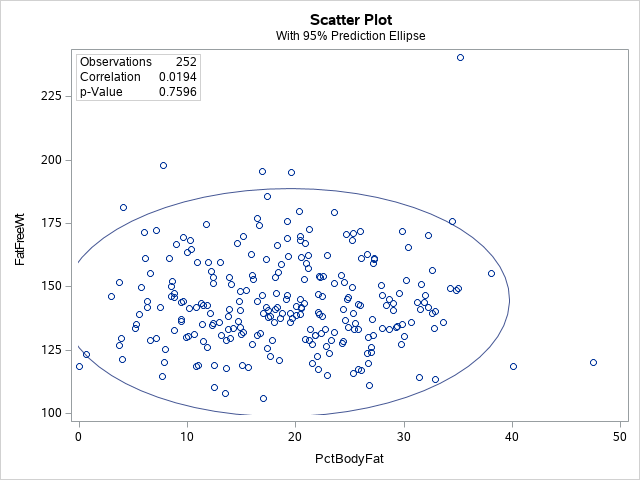

In [2]:
ods graphics on;
ods output PearsonCorr=result;
ods trace on;
proc corr data=work.BodyFat PEARSON
        /*
        Не получилось вывести все графики
        (NVAR=ALL requests that all variables in the VAR list be displayed with a maximum of 10)
        С помощью proc sgplot построить графики также не удалось.
        */
        plots=scatter(nvar=all);
    var PctBodyFat;
    with age weight height adioposity fatfreewt neck chest abdomen hip thigh knee ankle biceps forearm wrist;
run;
ods trace off;
ods graphics off;

In [3]:
data work.filtered;
    set work.result;
    if PPctBodyFat < 0.05 and PctBodyFat > 0.3 then output work.filtered;
run;

proc print data=work.filtered;
run;

Obs,Variable,PctBodyFat,PPctBodyFat
1,Weight,0.61241,<.0001
2,Adioposity,0.72748,<.0001
3,Neck,0.49059,<.0001
4,Chest,0.70262,<.0001
5,Abdomen,0.81343,<.0001
6,Hip,0.62520,<.0001
7,Thigh,0.55961,<.0001
8,Knee,0.50867,<.0001
9,Biceps,0.49327,<.0001
10,Forearm,0.36139,<.0001


In [4]:
proc sql noprint;
    select Variable into: inputs separated by ' ' from work.filtered;
run;
%put &inputs;

#### Q1.1: Укажите переменные:
- 3 переменные с максимальной корреляцией: (1) Abdomen ;(2) Adioposity ;(3) Chest ;
- укажите переменные, для которых коэф. корреляции не отличается значимо от нуля: (1) FatFreeWt ; (2) Height ;

#### Q1.2: Можно ли утверждать, что для 3-х переменных с максимальной корреляцией связь c целевой  действительно линейная? 
Не можем, т.к. мы просто отвергаем гипотезу нулевой корреляции между ними, но этого недостаточно, чтобы утверждать о линейной связи с целевой переменной.

### 2. Выбор моделей кандидатов  
#### 2.1 Пошаговые методы 
Из оставшихся переменных, используя proc reg и метод forward, проведите отбор предикторов. Какой порог на p-value нужно выбрать, чтобы в модель вошло только 5 переменных? Используйте этот порог. Создайте макропеременную model1, содержащую список выбранных переменных, и используйте ее, чтобы построить регрессию на этих переменных (еще один запуск proc reg).


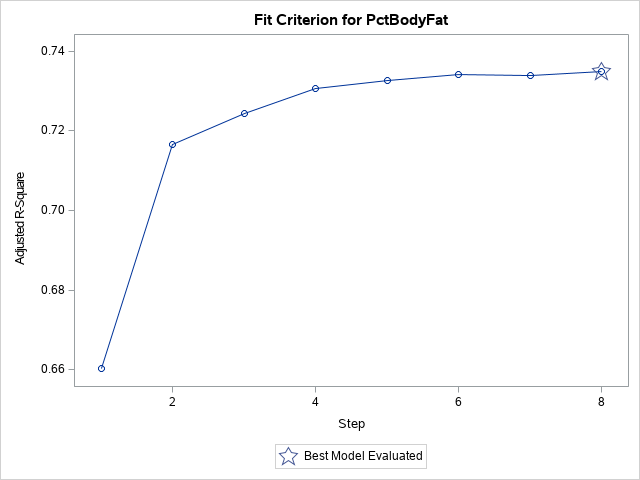
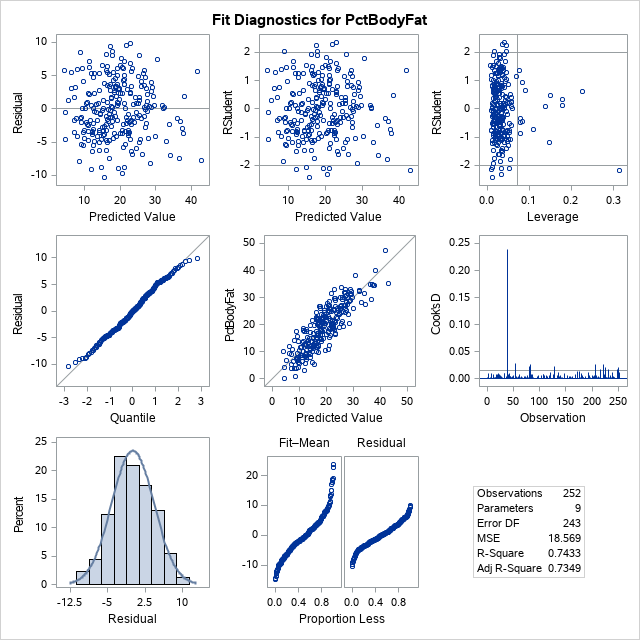
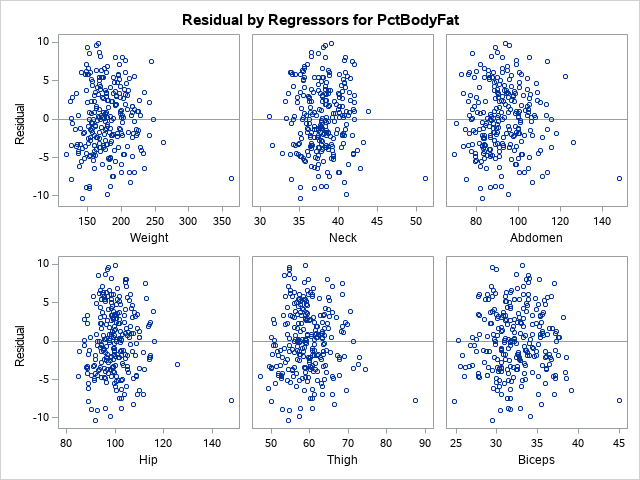
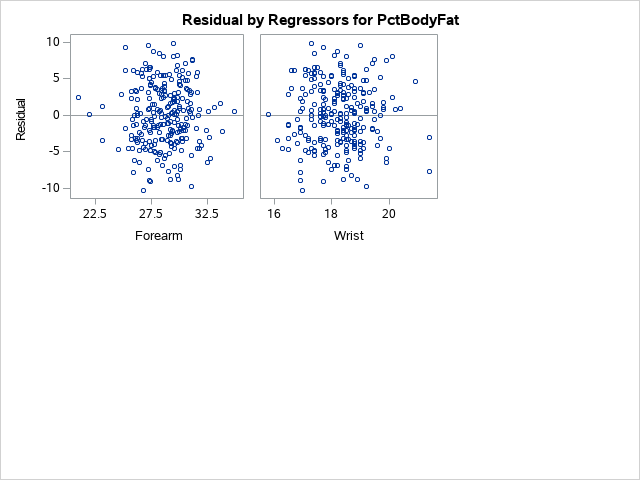

In [5]:
ods graphics on;
proc reg data=work.bodyfat plots=adjrsq;
    forward: model PctBodyFat
                    =&inputs
            / selection=forward;
run;
quit;
ods graphics off;


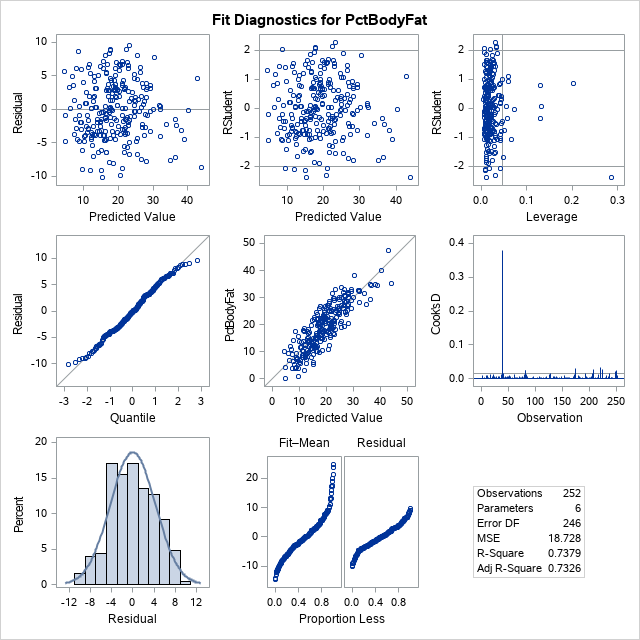
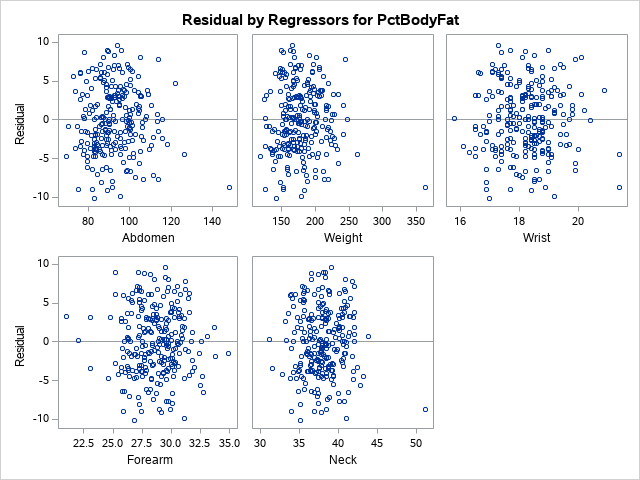

In [6]:
ods graphics on;
proc reg data=work.bodyfat;
    %let model1=abdomen weight wrist forearm neck;
    model PctBodyFat=&model1;
run;
quit;
ods graphics off;

In [7]:
%put &model1

#### Q2.1.1: На сколько увеличился R-квадрат модели, когда 5-я переменная была добавлена? 
0.7379 - 0.7350 = 0.7329
#### Q2.1.2 Какая переменная наиболее значимая в модели, какая  наименее? Почему вы так решили?
По наибольшему F Value в обеих моделях наиболее значимая и влияющая на R-Square - Abdomen. Наименьшая по значимости в model - Hip, в model1 - Neck.

#### 2.2 Перебор подмножеств
Определите набор предикторов (не более 5), при использовании которых можно получить модель не хуже (в качестве метрики для выбора используйте RMSE), чем в п. 2.1. Создайте макропеременную model2, содержащую список выбранных переменных, и используйте ее, чтобы построить регрессию на этих переменных (еще один запуск proc reg).


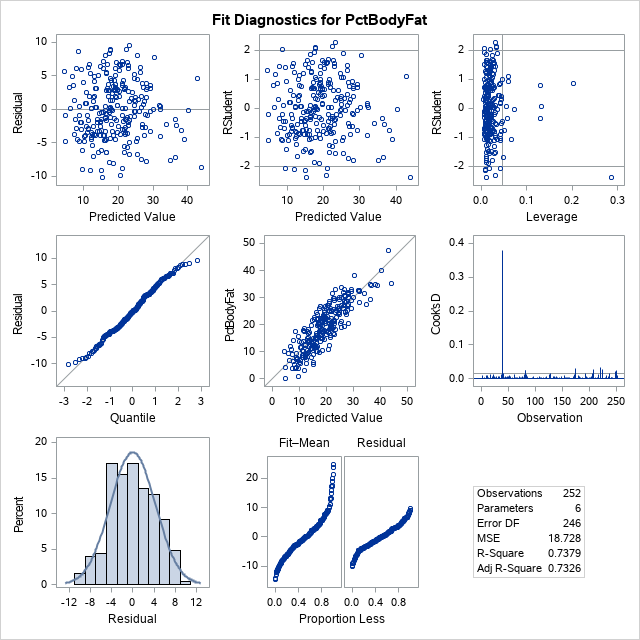
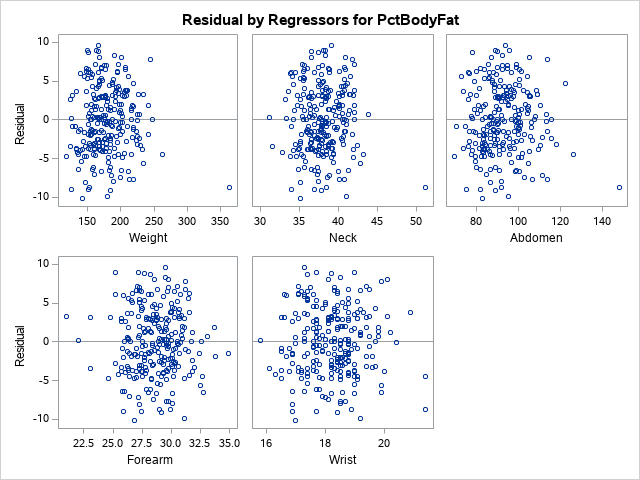

In [8]:
proc reg data=work.bodyfat rmse;
    all_reg: model PctBodyFat
                    =&inputs
            / selection=rsquare stop=5;
run;
quit;


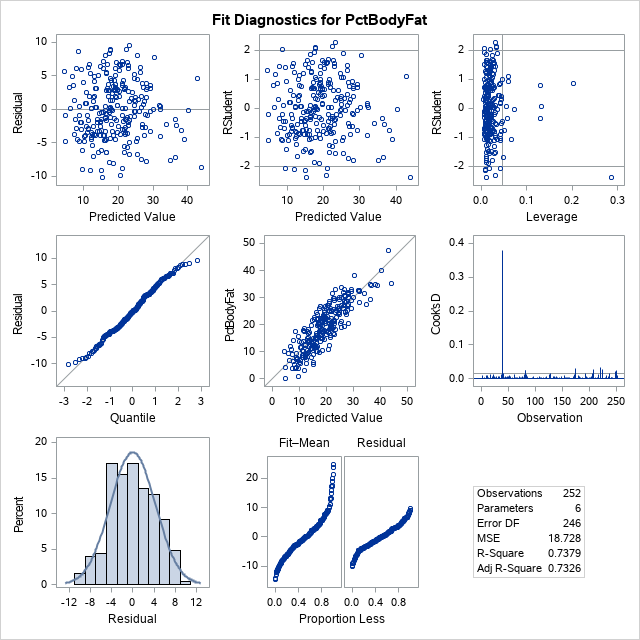
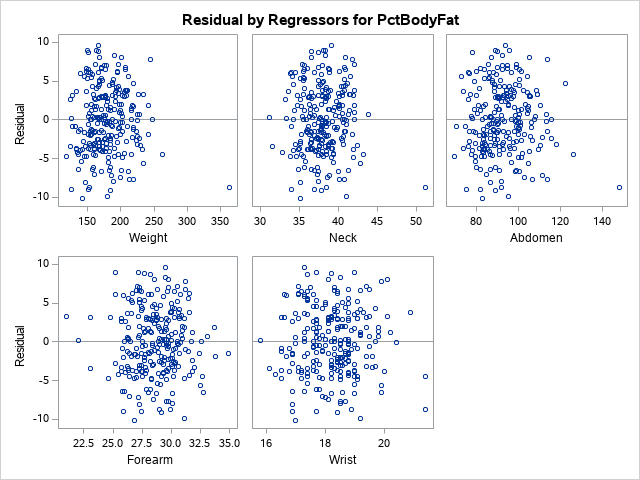

In [9]:
/* Лучший результат (0.7379, что к тому же эквивалентно model1, т.е. не хуже)
    у набора предикторов Weight Neck Abdomen Forearm Wrist. */
ods graphics on;
proc reg data=work.bodyfat;
    %let model2=weight neck abdomen forearm wrist;
    model PctBodyFat=&model2;
run;
quit;
ods graphics off;

#### Q2.2.1: Удалось ли построить модель лучше? 
Удалось лишь построить такую же, как model1.

### 3. Проверка предположений  
Выберете лучшую модель из двух, построенных ранее. Проверьте предположения регрессионного анализа для нее.


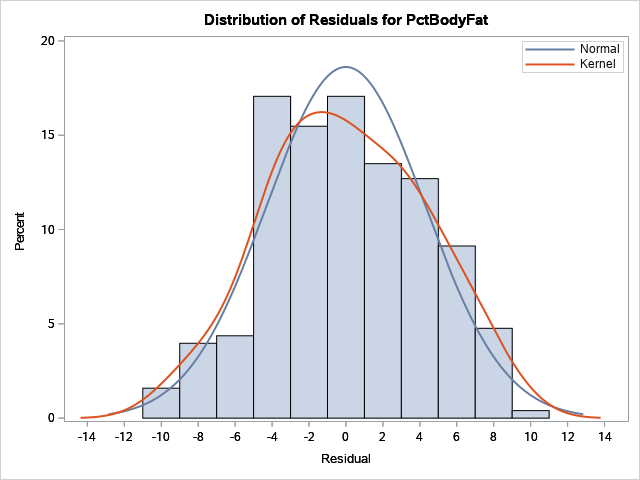
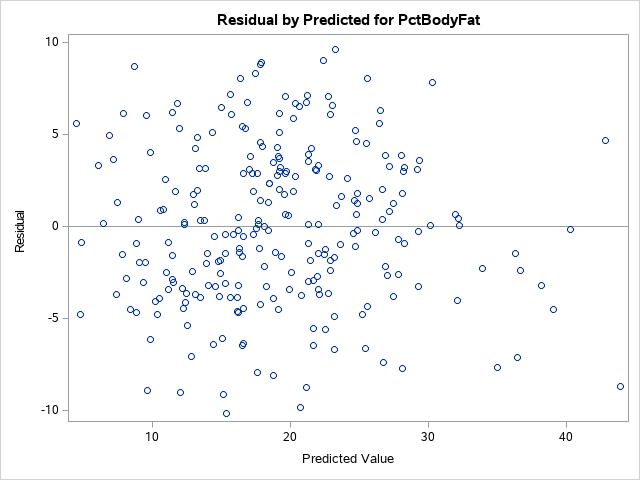
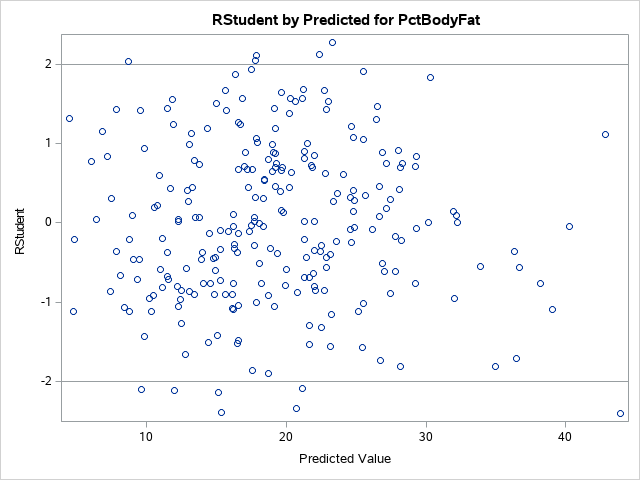
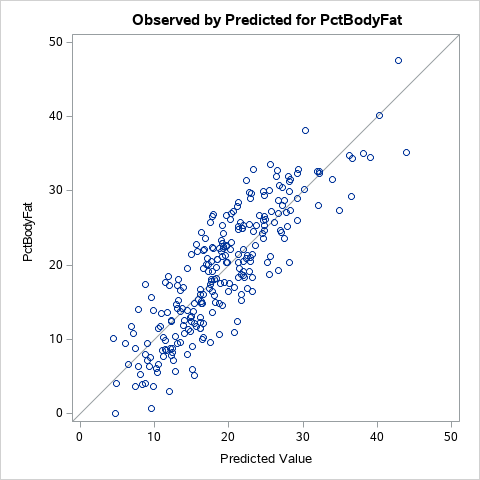
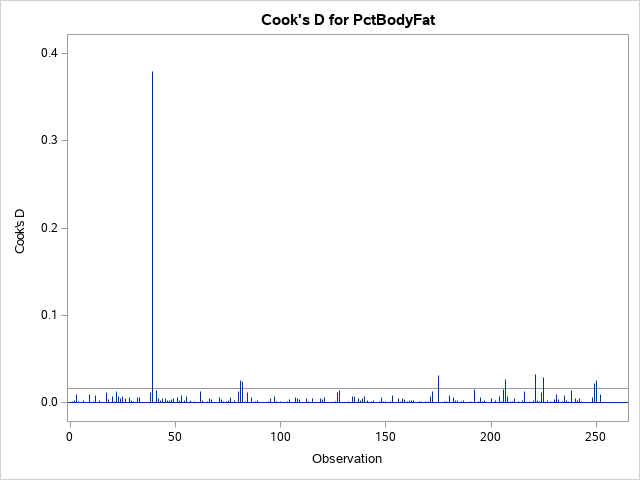
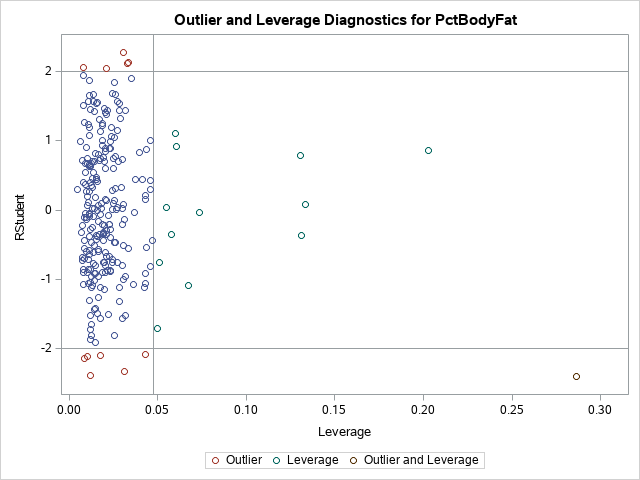
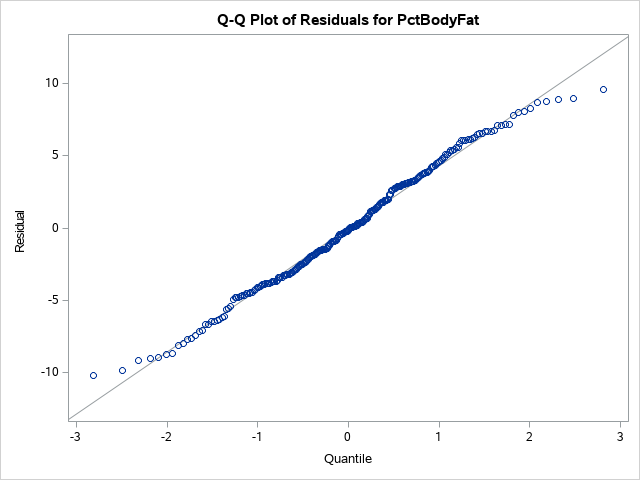
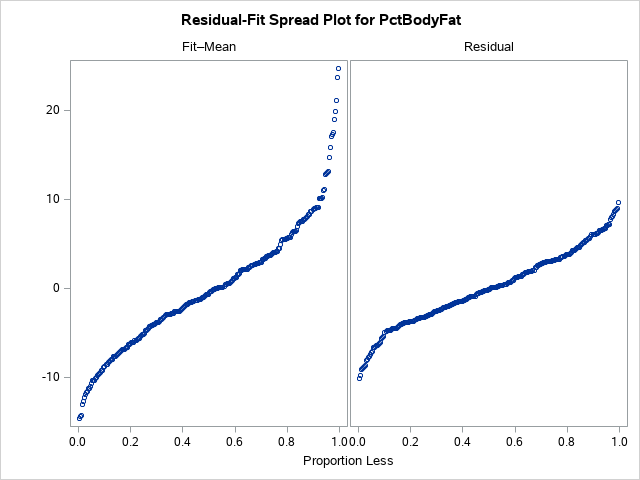
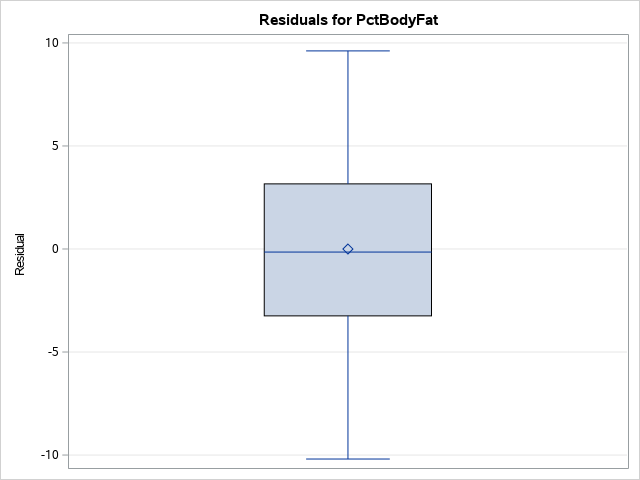
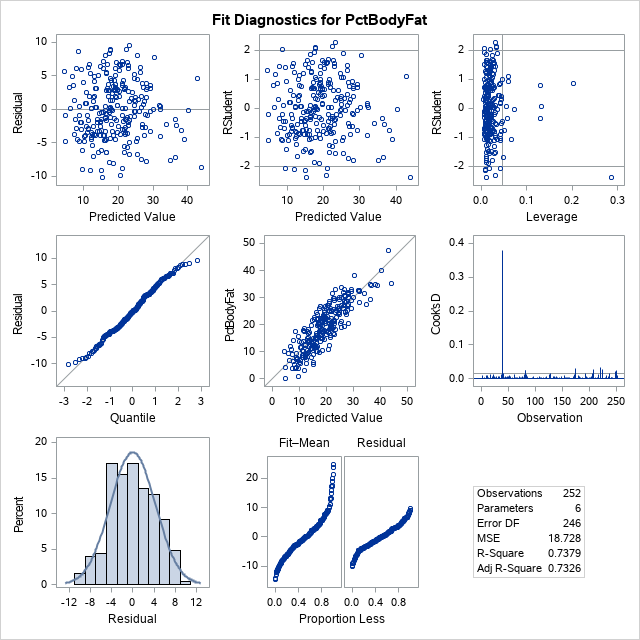
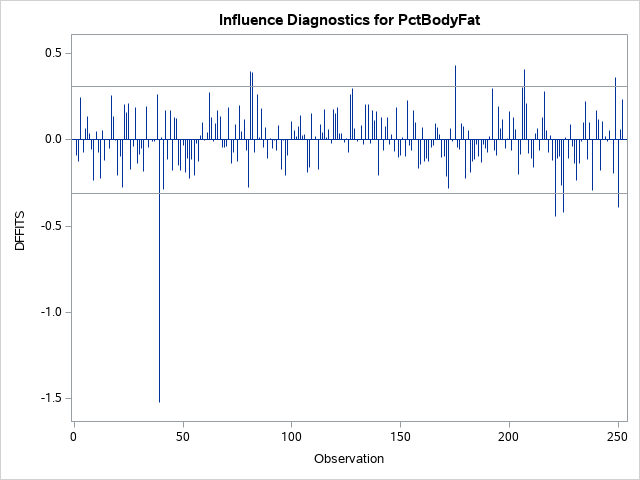
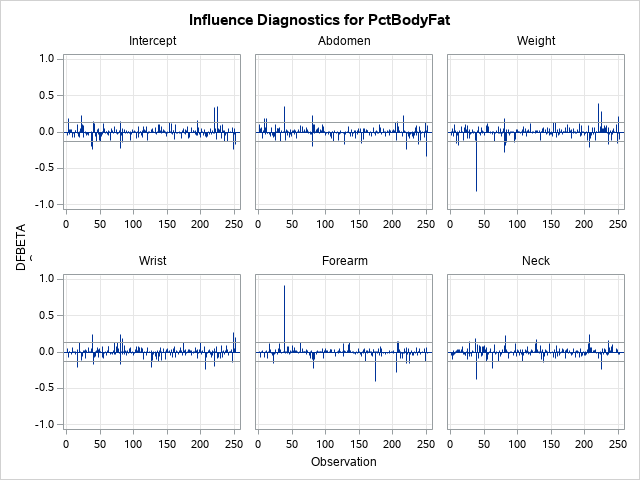
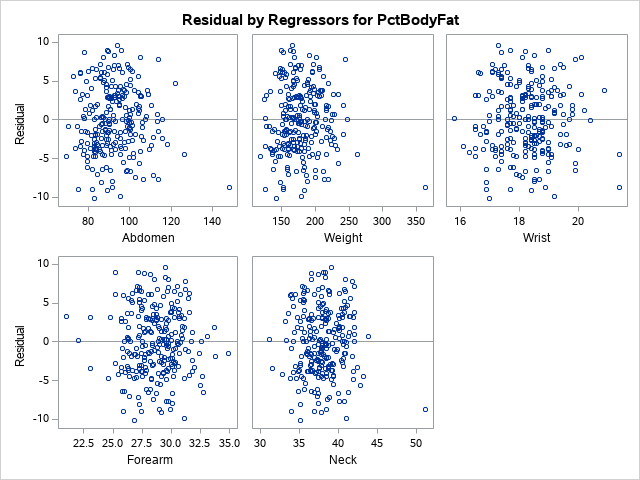

In [10]:
ods graphics on;
proc reg data=work.bodyfat plots=all;
    model PctBodyFat=&model1
    / white hcc hccmethod=0;
run;
quit;
ods graphics off;

#### Q3.1: Укажите, какие предположения выполнены, а какие нет? Обязательно объясните, на основании чего Вы сделали такой вывод.
(1) Independent observations - неизвестно, т.к. у нас нет деталей эксперимента

(2) Normally distributed error terms - выполнено, т.к. на соответствующем графике (Distribution of Residuals) видно, что ядро почти совпадает с графиком нормального распределения. Ещё более нагляден Q-Q (quantile-quantile) Plot of residuals

(3) Constant variance - графики Residual by Predicted и by Regressors, в принципе, похожи на те, что были на лекциях, но обосновать не могу :(

(4) Linear relation between E[Y] and x - выполнено, график Residual-Fit Spread по "вытянутости" соответствует линейной зависимости


### 4. Поиск и исключение влиятельных наблюдений 
Используя статистику Cook's D, найдите два наиболее влятельных наблюдения в данных. Удалите их из набора.


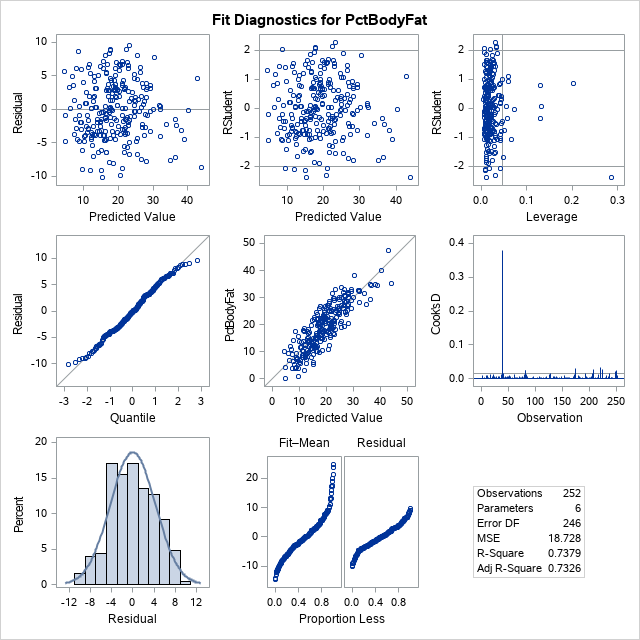
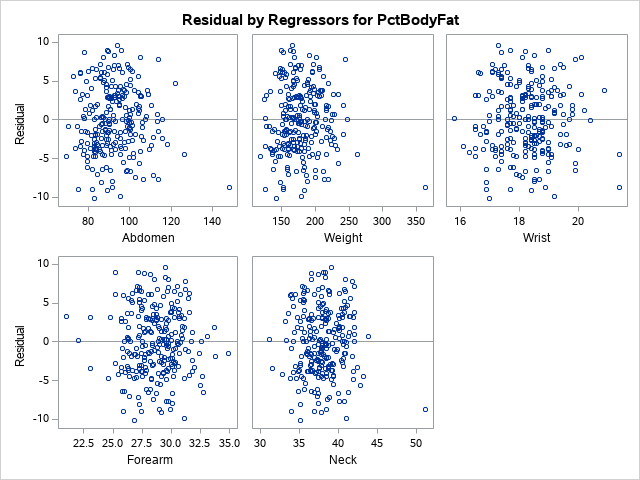

In [11]:
proc reg data=work.bodyfat;
    model PctBodyFat=&model1
    / influence;
    output out=influence cookd=most;
run;

In [12]:
proc sql;
    create table sorted as
        select *
        from work.influence
        order by most desc
        ;
run;

title 'Two most influential observations:';
proc print data=work.sorted(obs=2);
run;

title 'All observations:';
proc print data=work.sorted;
run;

proc sql;
    create table work.bodyfat as
        select *
        from work.bodyfat as t
        where t.case ~= 39 and t.case ~= 221
        ;
quit;

Obs,Case,PctBodyFat,Age,Weight,Height,Adioposity,FatFreeWt,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,most
1,39,35.2,46,363.15,72.25,48.9,240.5,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,0.37897
2,221,12.4,54,153.25,70.50,24.5,151.3,38.5,99.0,91.8,96.2,57.7,38.1,23.9,31.4,29.9,18.9,0.03207
Obs,Case,PctBodyFat,Age,Weight,Height,Adioposity,FatFreeWt,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,most
1,39,35.2,46,363.15,72.25,48.9,240.5,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,0.37897
2,221,12.4,54,153.25,70.50,24.5,151.3,38.5,99.0,91.8,96.2,57.7,38.1,23.9,31.4,29.9,18.9,0.03207
3,175,25.3,36,226.75,71.75,31.0,170.9,41.5,115.3,108.8,114.4,69.2,42.4,24.0,35.4,21.0,20.1,0.03105
4,225,10.9,55,179.75,68.75,26.8,159.5,41.1,106.9,95.3,98.2,57.4,37.1,21.8,34.1,31.1,19.2,0.02869
5,207,32.9,44,166.00,65.50,27.2,113.5,39.1,100.6,93.9,100.1,58.9,37.6,21.4,33.1,29.5,17.3,0.02699
6,81,31.4,67,163.75,67.75,25.1,114.3,38.4,97.7,95.8,97.1,54.8,38.2,23.7,29.4,27.2,19.0,0.02554
7,250,29.3,72,186.75,66.00,30.2,133.9,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,0.02530


### Q4.1: Укажите номера найденных влиятельных наблюдений
(1) 39;
(2) 221;
#### Q4.2: Используя рекомендуемый порог для статитстики Cook's D - сколько наблюдений нужно было бы удалить?
CooksD > 4/n => CooksD > 4/252 = 0,015873016 => 9 наблюдений

### 5. Исследование коллинеарности
Проведите исследование на наборе с удаленными влиятельными наблюдениями. Используйте опцию VIF, чтобы выявить наиболее проблемную переменную, и опцию collinoint, чтобы выявить с какими переменными найденная проблемная коррелирует.  


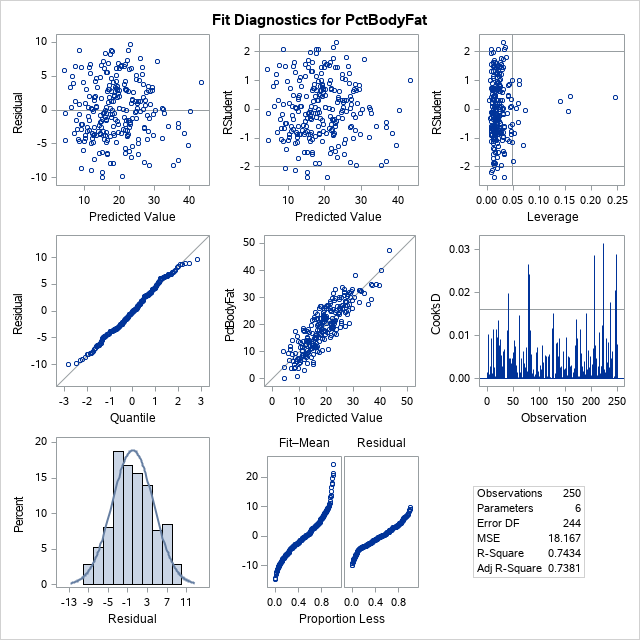
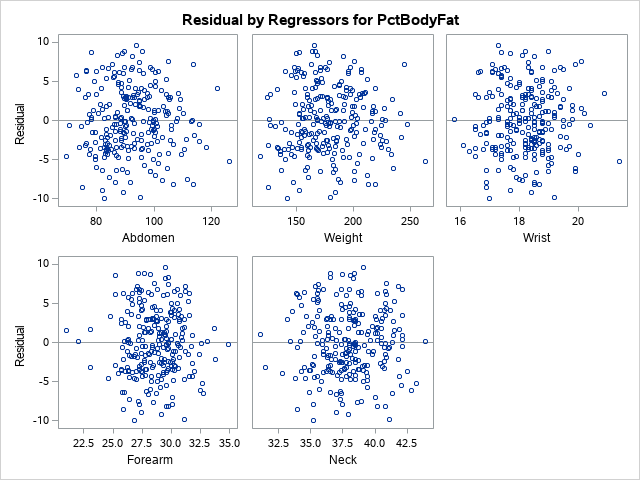

In [13]:
proc reg data=work.bodyfat;
    model PctBodyFat=&model1
    / VIF collinoint;
run;
quit;

#### Q5.1: Укажите наиболее проблемную переменную, почему вы ее выбрали?
(1) По максимальному Variance Inflation -- Weight;
#### Q5.2: С какими переменными она коррелирует? Почему? 
(1) Abdomen;

**Подтвердите свои выводы запуском процедуры proc corr:**

In [14]:
proc corr data=work.bodyfat;
    var weight; with Abdomen Wrist Forearm Neck;
run;

#### Q5.3: Подтвердились ли выводы? Почему Вы так решили? 
Да, т.к. у них наивысший коэффициент корреляции Пирсона (0.87558) в сравнении с остальным предикторами;
#### Q5.4 Удалите из модели проблемную и наиболее коррелирующую с ней? Как изменилась метрика RMSE?
Стремительно увеличилась;


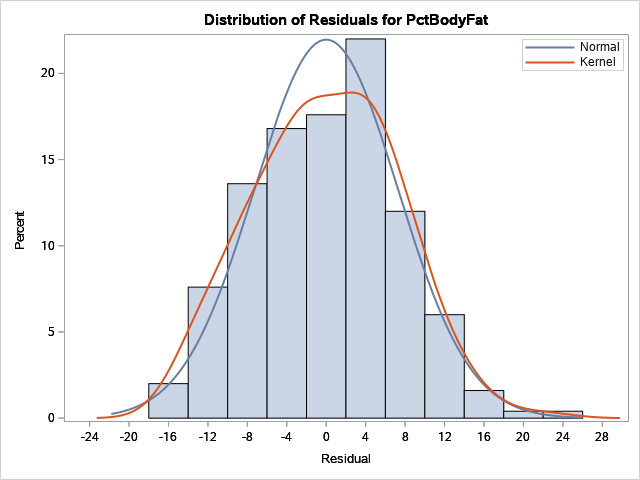
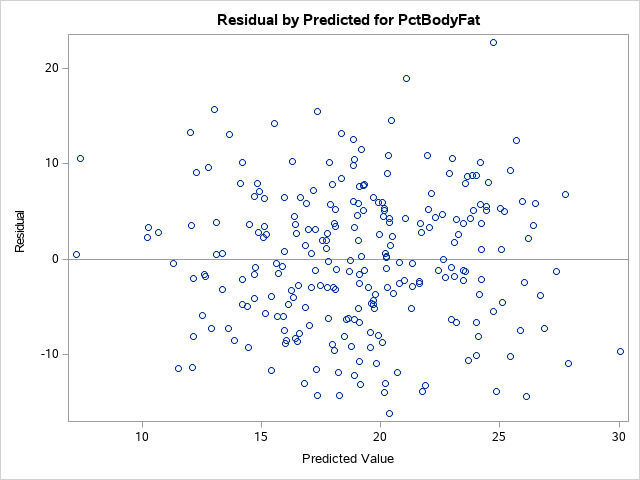
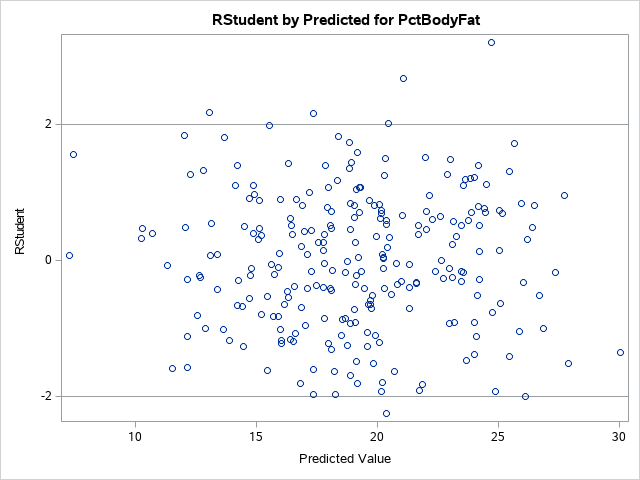
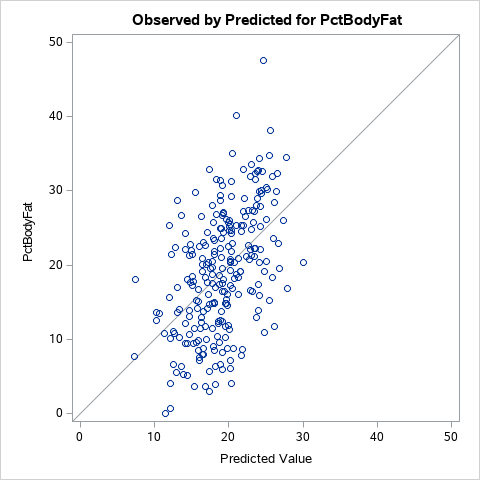
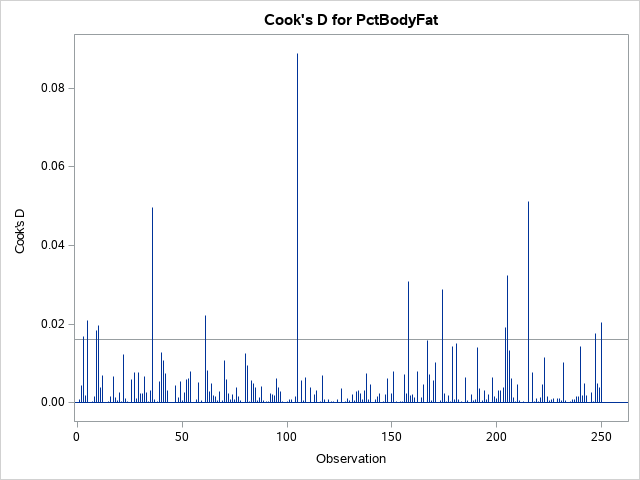
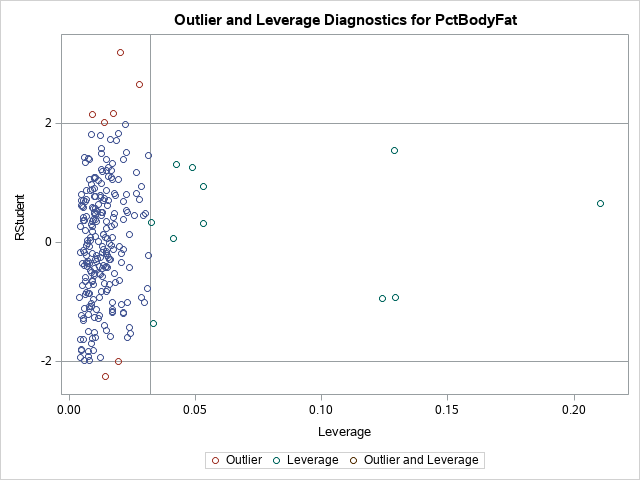
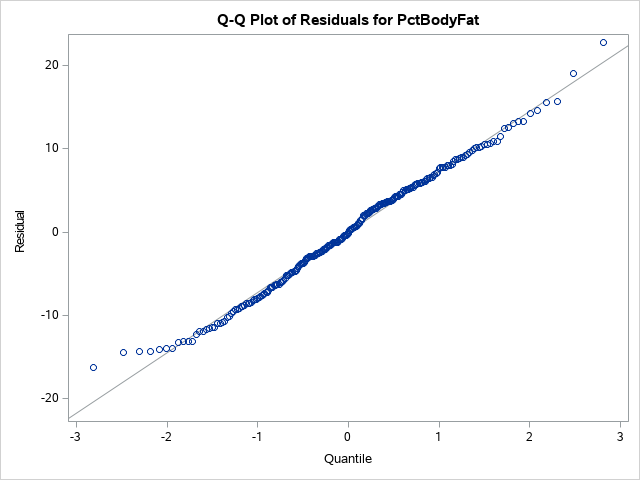
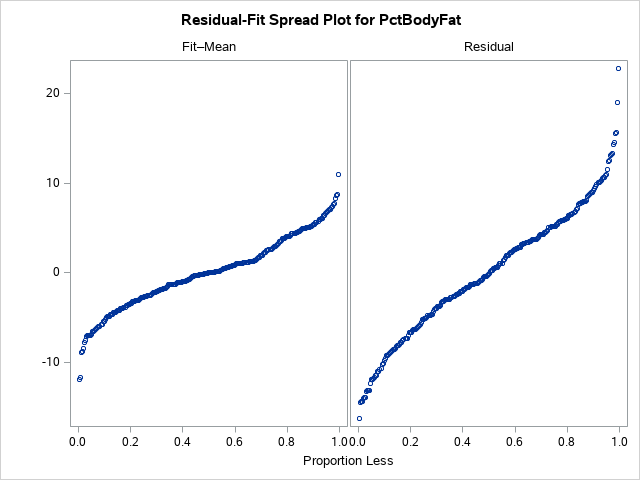
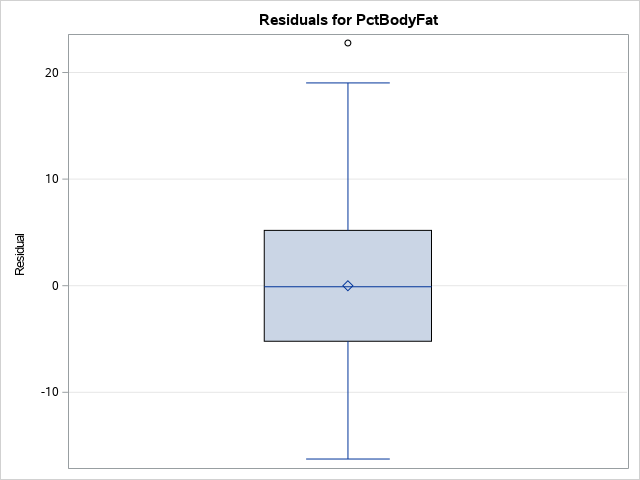
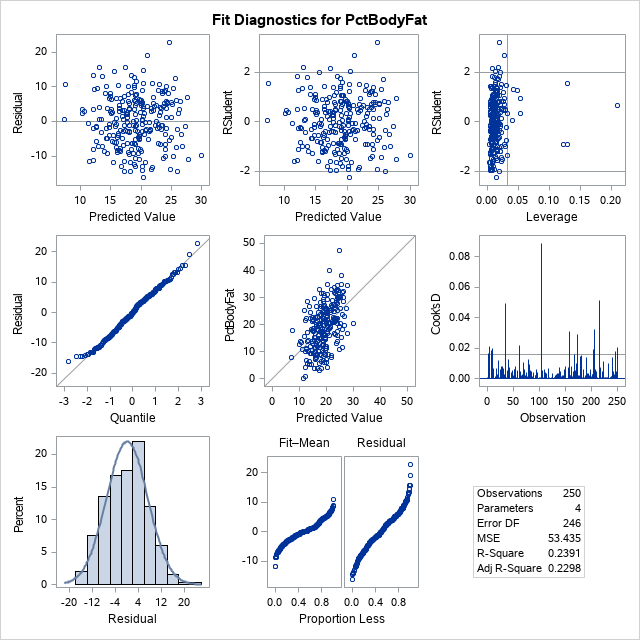
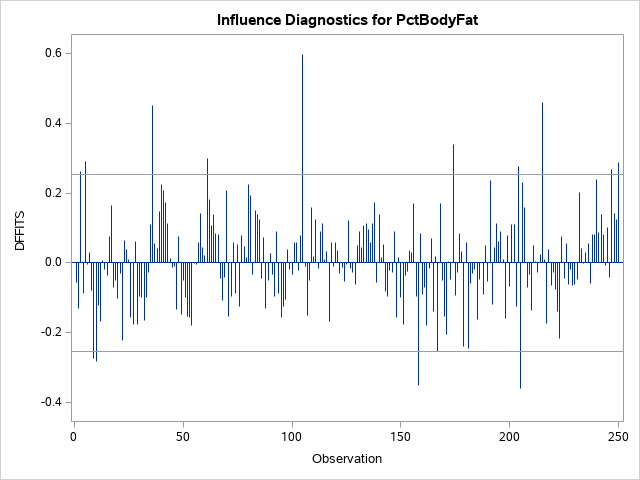
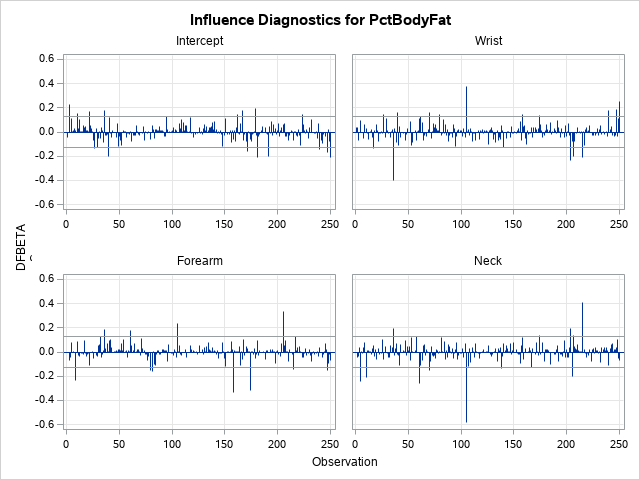
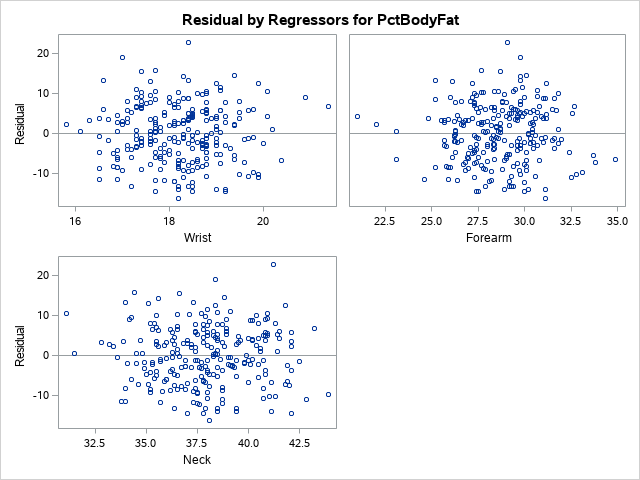

In [15]:
proc reg data=work.bodyfat RMSE plots=all;
    model PctBodyFat=Wrist Forearm Neck;
run;
quit;